In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('dark')
plt.rcParams['font.family'] = 'Palatino Linotype'

In [2]:
# 训练数据的范围
TRAIN_LEFT = 300000
TRAIN_RIGHT = 340000
# 异常数据所在的范围
L_1 = 449092
R_1 = 449961
L_2 = 521261
R_2 = 521388
L_3 = 529624
R_3 = 530171

# Pytorch DenseAutoEncoder

## 设置随机种子

In [3]:
import torch
import torch.nn as nn 

In [4]:
np.random.seed(1)
torch.manual_seed(2)
SEED = 123

## 创建全连接AE的dataset

In [5]:
# 数据加载的基类
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x):
        super(Dataset,self).__init__()
        self.dataset = x
    def __len__(self):
        # 重载
        return len(self.dataset)
    def __getitem__(self,idx):
        # 重载
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'flag'}) # 丢掉flag列
        tensor = torch.from_numpy(np.array(row)).float() # 将array转换为tensor
        return tensor

## 搭建全连接AutoEncoder

In [6]:
# 自编码器
class AutoEncoder(nn.Module):
    def __init__(self,input_dim):
        super(AutoEncoder,self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            # nn.Linear(input_dim,128),
            # nn.ReLU(),
            # nn.Linear(128,64),
            # nn.ReLU(),
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU()
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,input_dim),
            nn.ReLU(),
            # nn.Linear(128,256),
            # nn.ReLU(),
            # nn.Linear(256,512),
            # nn.ReLU(),
            # nn.Linear(512,input_dim),
            # nn.ReLU()
        )

    def forward(self,x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)

        return decoder

## 全连接AutoEncoder数据标准化

In [7]:
data = pd.read_csv('data_8487.csv',index_col=0)

In [8]:
data.head(n=3)

,max_bat_mer_v,min_bat_mer_v,max_temp,min_temp,total_voltage,total_current,soc,mbv0,mbv1,mbv2,...,etpd39,etpd40,etpd41,etpd42,etpd43,etpd44,etpd45,etpd46,etpd47,flag
300000,3.786,3.755,16,14,362.1,-40.0,62,3.769,3.769,3.773,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0
300001,3.796,3.751,16,14,361.8,11.0,62,3.763,3.763,3.767,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0
300002,3.769,3.742,16,14,361.0,19.0,62,3.763,3.763,3.766,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0


## 数据集分割

In [9]:
train_data,train_flag = data.loc[TRAIN_LEFT:TRAIN_RIGHT].drop('flag',axis=1),data.loc[TRAIN_LEFT:TRAIN_RIGHT]['flag']
valid_data = pd.concat(
    [
        data.loc[TRAIN_RIGHT:TRAIN_RIGHT+5000].drop('flag',axis=1),
        data.loc[L_1:R_1].drop('flag',axis=1)
    ]
)
valid_flag = pd.concat(
    [
        data.loc[TRAIN_RIGHT:TRAIN_RIGHT+5000]['flag'],
        data.loc[L_1:R_1]['flag']
    ]
)
test_data = pd.concat(
    [
        data.loc[TRAIN_RIGHT+5000:TRAIN_RIGHT+10000].drop('flag',axis=1),
        data.loc[L_2:R_2].drop('flag',axis=1),
        data.loc[L_3:R_3].drop('flag',axis=1)
    ]
)
test_flag = pd.concat(
    [
        data.loc[TRAIN_RIGHT+5000:TRAIN_RIGHT+10000]['flag'],
        data.loc[L_2:R_2]['flag'],
        data.loc[L_3:R_3]['flag']
    ]
)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_data)

train_data = scaler.transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)

train_data = pd.DataFrame(data=np.concatenate((train_data,train_flag.values.reshape(-1,1)),axis=1),index=train_flag.index,columns=data.columns)
valid_data = pd.DataFrame(data=np.concatenate((valid_data,valid_flag.values.reshape(-1,1)),axis=1),index=valid_flag.index,columns=data.columns)
test_data = pd.DataFrame(data=np.concatenate((test_data,test_flag.values.reshape(-1,1)),axis=1),index=test_flag.index,columns=data.columns)

In [15]:
train_data.head(n=3)

,max_bat_mer_v,min_bat_mer_v,max_temp,min_temp,total_voltage,total_current,soc,mbv0,mbv1,mbv2,...,etpd39,etpd40,etpd41,etpd42,etpd43,etpd44,etpd45,etpd46,etpd47,flag
300000,-0.139363,-0.117169,0.070798,0.212507,-0.133025,-1.163714,0.076585,-0.150230,-0.145135,-0.143481,...,0.196029,0.206441,0.2921,0.294096,0.254574,0.151333,0.14219,0.271995,0.256523,0.0
300001,-0.082703,-0.139705,0.070798,0.212507,-0.150659,0.330747,0.076585,-0.184319,-0.179287,-0.177286,...,0.196029,0.206441,0.2921,0.294096,0.254574,0.151333,0.14219,0.271995,0.256523,0.0
300002,-0.235684,-0.190412,0.070798,0.212507,-0.197684,0.565172,0.076585,-0.184319,-0.179287,-0.182920,...,0.196029,0.206441,0.2921,0.294096,0.254574,0.151333,0.14219,0.271995,0.256523,0.0


## 训练前准备工作 创建数据loader和赋值超参

In [16]:
# 超参数
BATCH_SIZE = 32 # 每批数据的量
LR = 1e-2 # 学习率
MOMENTUM = 0.9 
DECAY = 1e-5 # 权重衰减
EPOCHS = 30 # 训练回合数

In [18]:
from collections import defaultdict
# 使用gpu训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'

metrics = defaultdict(list)

# 加载数据
train_set = Dataset(x=train_data)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# 创建自编码器工作
model = AutoEncoder(input_dim=train_data.shape[1]-1)
model.to(device)

# 损失函数 MSE
criterion = nn.MSELoss(reduction='mean')
# 优化器 SGD
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = LR,
    weight_decay = DECAY
)

## Training

In [19]:
model.train() # 将model设置为训练状态
for epoch in range(EPOCHS):
    running_loss = 0.0
    for _, data in enumerate(train_loader):
        sample = model(data.to(device)) # 将数据送入模型
        loss = criterion(data.to(device),sample) # 计算误差
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_set)
    if (epoch % 2 == 0):
        print('Epoch:{} Train_Loss:{}'.format(epoch,epoch_loss))
    metrics['train_loss'].append(epoch_loss)
torch.save(model.state_dict(),'car_8487_fcae.pth') # 保存模型
np.savetxt('car_8487_fcae_train_loss.txt',np.array(metrics['train_loss'])) # 保存模型训练loss

Epoch:0 Train_Loss:0.03128529653820746
Epoch:2 Train_Loss:0.02251777353577249
Epoch:4 Train_Loss:0.02229146372496803
Epoch:6 Train_Loss:0.022154746325366906
Epoch:8 Train_Loss:0.017606250827203573
Epoch:10 Train_Loss:0.017373720343919197
Epoch:12 Train_Loss:0.017361555392198396
Epoch:14 Train_Loss:0.017356258264640184
Epoch:16 Train_Loss:0.017354105084285906
Epoch:18 Train_Loss:0.017352381937712606
Epoch:20 Train_Loss:0.017350881831359452
Epoch:22 Train_Loss:0.017349829042957104
Epoch:24 Train_Loss:0.017348477045228097
Epoch:26 Train_Loss:0.01734731780112122
Epoch:28 Train_Loss:0.01734822016010159


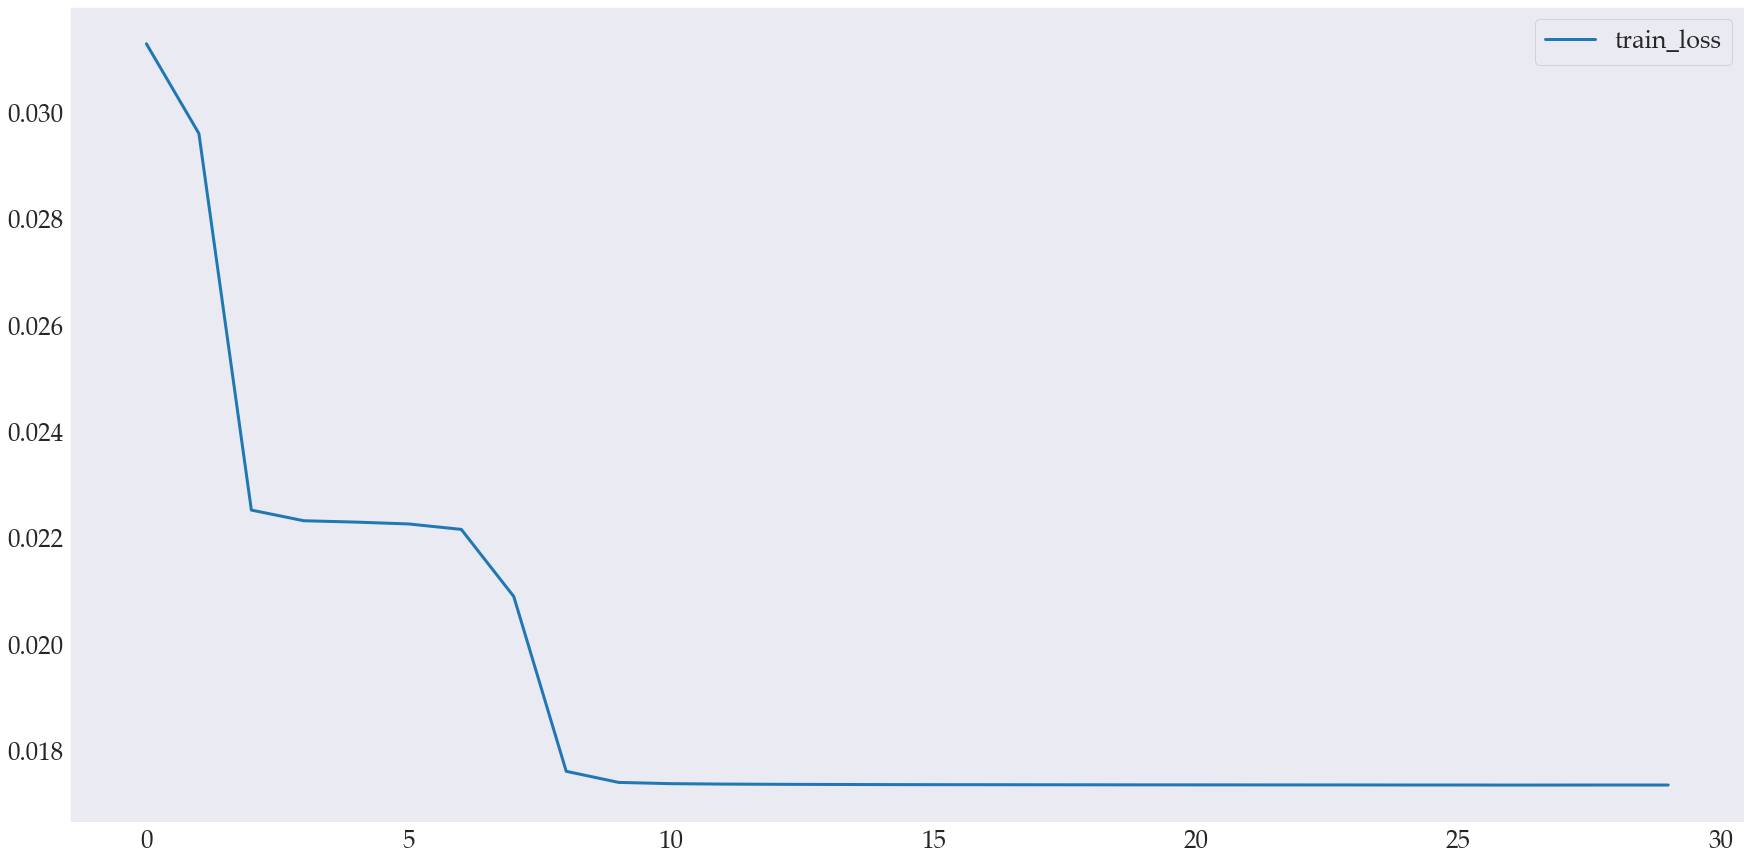

In [20]:
fig = plt.figure(figsize=(30,15))

plt.rc('font',size=20)
plt.ticklabel_format(style='sci')
plt.tick_params(labelsize=25)
plt.plot(metrics['train_loss'],linewidth=3,label='train_loss')
plt.legend(fontsize=25)

plt.show()

## Validation集设置Threshold

In [21]:
from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import recall_score,classification_report,auc,roc_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [22]:
model.eval() # 将模型调至evaluation模式
for idx,row in valid_data.iterrows():
    data = row.drop(labels={'flag'})
    data = torch.from_numpy(np.array(data)).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device),sample)
    metrics['validation_loss'].append(loss.item())

np.savetxt('car_8487_fcae_validation_loss.txt',np.array(metrics['validation_loss'])) # 保存模型 validation loss
loss_df = pd.DataFrame({'rebuilt_loss':metrics['validation_loss'],'flag':valid_data['flag']})

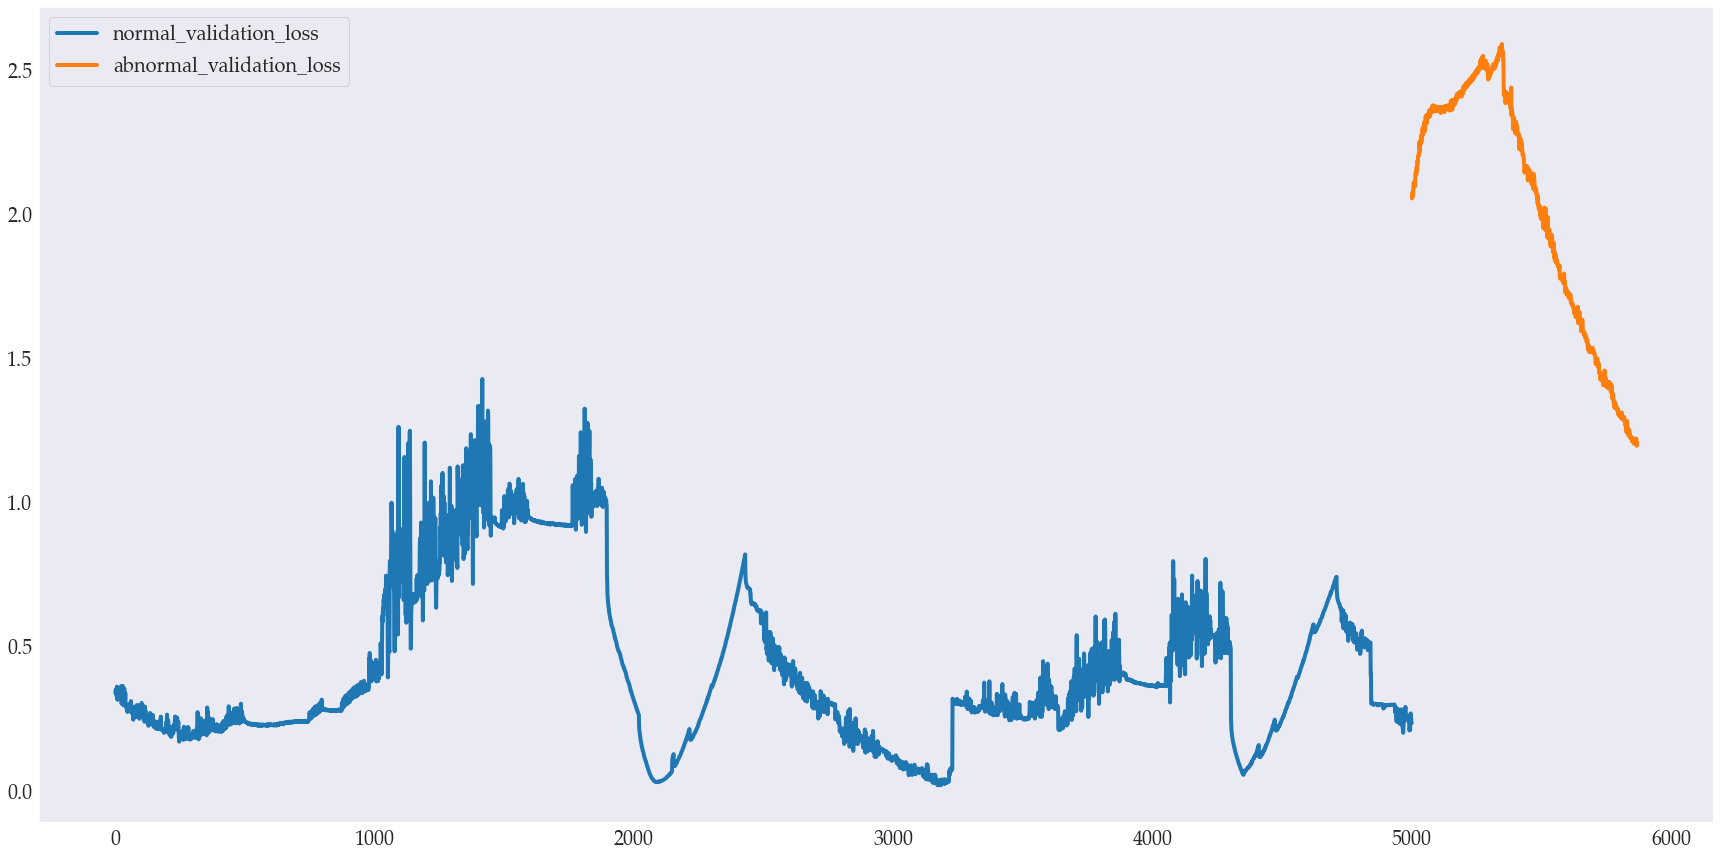

In [23]:
tmp_df = loss_df.reset_index()

fig = plt.figure(figsize=(30,15))
plt.plot(tmp_df[tmp_df['flag']==0]['rebuilt_loss'],label='normal_validation_loss',linewidth=4)
plt.plot(tmp_df[tmp_df['flag']==1]['rebuilt_loss'],label='abnormal_validation_loss',linewidth=4)
plt.legend()
plt.show()

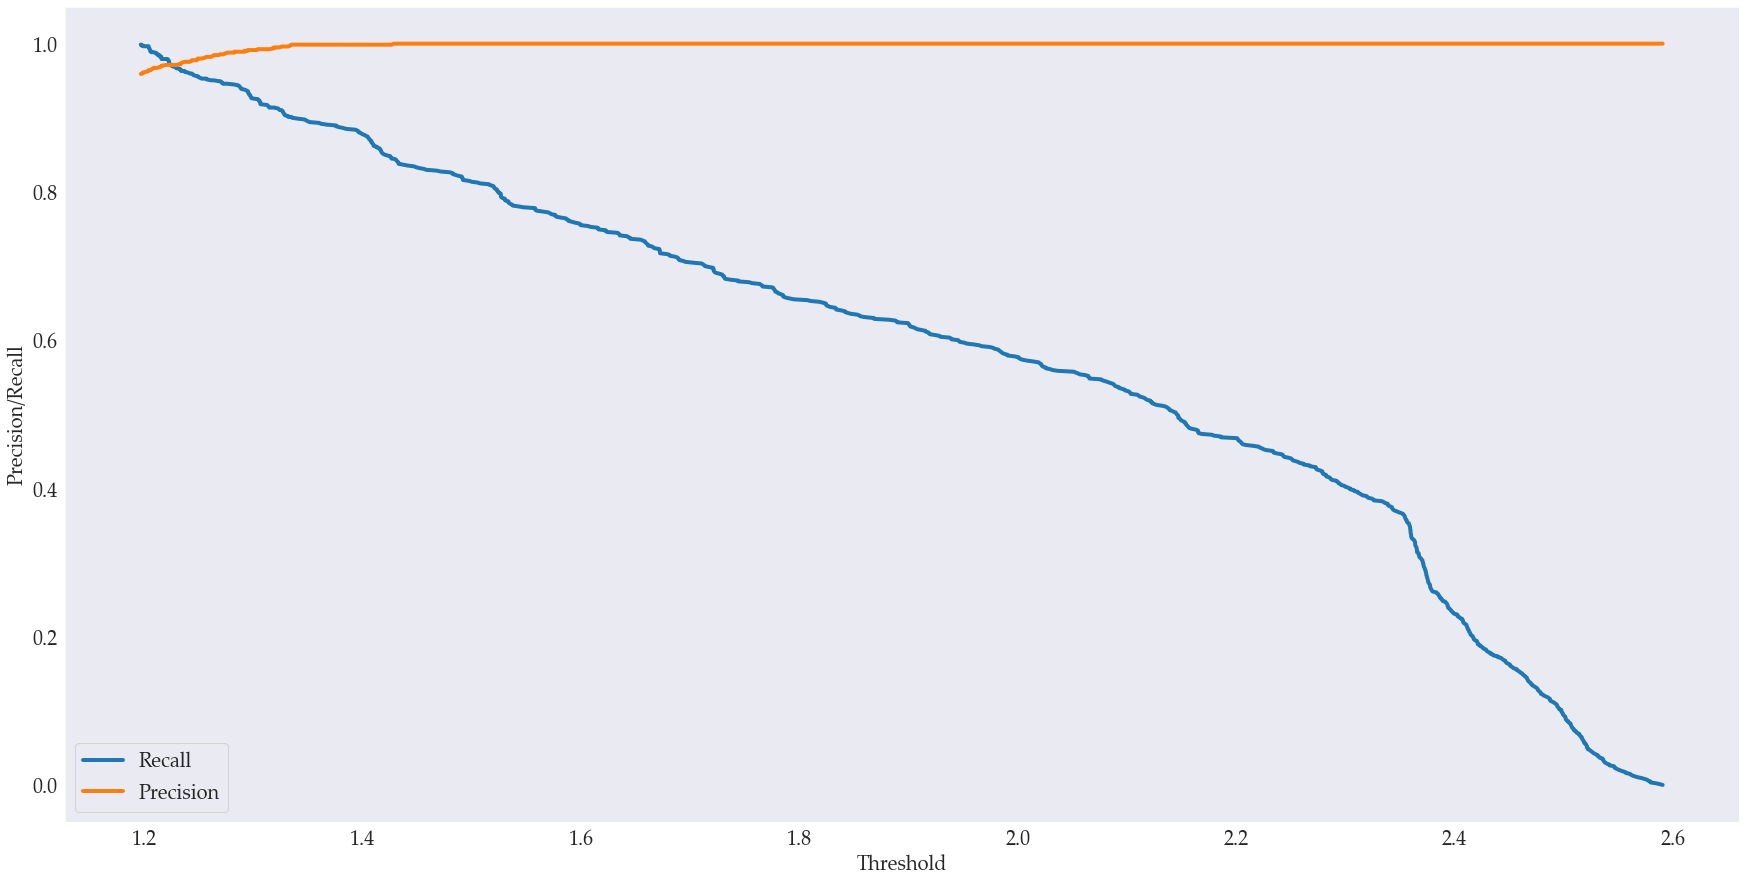

In [24]:
precision_rt,recall_rt,threshold_rt = precision_recall_curve(loss_df.flag,loss_df.rebuilt_loss)

fig = plt.figure(figsize=(30,15))
plt.rc('font',size=20)
plt.plot(threshold_rt,recall_rt[1:],label='Recall',linewidth=4)
plt.plot(threshold_rt,precision_rt[1:],label='Precision',linewidth=4)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

plt.show()

## 测试集测试模型的性能

In [25]:
metrics['test_loss'] = []
for idx,row in test_data.iterrows():
    data = row.drop(labels={'flag'})
    data = torch.from_numpy(np.array(data)).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device),sample)
    metrics['test_loss'].append(loss.item())

np.savetxt('car_8487_fcae_test_loss.txt',np.array(metrics['test_loss'])) # 保存模型训练loss

<Figure size 2160x1080 with 0 Axes>

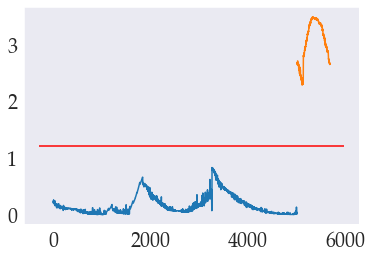

In [26]:
THRESHOLD = 1.22

test_loss_df = pd.DataFrame({'rebuilt_loss':metrics['test_loss'],'flag':test_data['flag']})
tmp_df = test_loss_df.reset_index()

groups = tmp_df.groupby('flag')

plt.figure(figsize=(30,15))
fig,ax = plt.subplots()
plt.rc('font',size=20)
for name,group in groups:
    ax.plot(group.index,group.rebuilt_loss,label='Abnormal' if name==1 else 'Normal')
ax.hlines(THRESHOLD,ax.get_xlim()[0],ax.get_xlim()[1],colors='r',label='Threshold')

plt.show()